In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

2025-12-23 23:34:21.921078: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-23 23:34:21.932600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766504061.945905    2951 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766504061.949508    2951 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-23 23:34:21.964446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
CSV_PATH = '/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/train_labels.csv'
IMG_DIR = '/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/DATASET/train'
BATCH_SIZE = 32

In [3]:
import pandas as pd
from sklearn.utils import resample
df = pd.read_csv(CSV_PATH, header=None, names=['image', 'label'])
df['image'] = df['image'].astype(str)

target_negatives = ['1', '4', '7']
target_positive = ['6']

df_neg = df[df['label'].isin(target_negatives)].copy()
df_pos = df[df['label'].isin(target_positive)].copy()
print(f"正樣本 (Anger) 數量: {len(df_pos)}")
print(f"負樣本 (Non-Anger) 數量: {len(df_neg)}")

# Downsampling - 調整為更接近真實測試分布的比例
# 測試集比例約為 13.5:1，這裡使用 8:1 作為折衷
NEG_POS_RATIO = 8
n_neg_samples = min(len(df_neg), len(df_pos) * NEG_POS_RATIO)
df_neg_downsampled = resample(df_neg, 
                              replace=False,    # 不放回
                              n_samples=n_neg_samples,
                              random_state=42)

# 合併與打亂
df_balanced = pd.concat([df_pos, df_neg_downsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# 6 -> '1' (Anger)
# Others -> '0' (Non-Anger)
df_balanced['binary_label'] = df_balanced['label'].apply(lambda x: '1' if str(x) == '6' else '0')
# 修正：影像在標籤子目錄中，格式為 IMG_DIR/label/filename
df_balanced['image_full_path'] = df_balanced.apply(
    lambda row: os.path.join(IMG_DIR, str(row['label']), row['image']), 
    axis=1
)

print(f"\n訓練資料標籤分佈 (負:正 = {NEG_POS_RATIO}:1):")
print(df_balanced['binary_label'].value_counts())

正樣本 (Anger) 數量: 705
負樣本 (Non-Anger) 數量: 8586

訓練資料標籤分佈 (負:正 = 8:1):
binary_label
0    5640
1     705
Name: count, dtype: int64


In [4]:
# 不使用 class_weight，讓資料比例自己說話
# 這樣可以避免模型過度預測正樣本，提升 Precision
class_weights_dict = None
print("class_weight: None (不使用，由資料比例控制)")

class_weight: None (不使用，由資料比例控制)


In [5]:
def setup_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"已偵測到 GPU: {len(gpus)} 個，並開啟記憶體動態增長")
        except RuntimeError as e:
            print(e)
    else:
        print("未偵測到 GPU，將使用 CPU 訓練 (速度會很慢)")

setup_gpu()

已偵測到 GPU: 1 個，並開啟記憶體動態增長


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['binary_label'], random_state=42)
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_full_path',
    y_col='binary_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['0','1'],
    shuffle=True,
    seed=42
)
val_generator = val_data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_full_path',
    y_col='binary_label',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['0','1'],
    shuffle=False,
)

Found 5076 validated image filenames belonging to 2 classes.
Found 1269 validated image filenames belonging to 2 classes.


In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
def build_model():
  base_model = ResNet50(
      weights='imagenet',
      include_top=False,
      input_shape=(224,224,3)
  )
  base_model.trainable = False
  inputs = layers.Input(shape=(224,224,3))
  x = base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-4),
      loss='binary_crossentropy',
      metrics=[
          'accuracy', 
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.Precision(name='precision')
      ]
  )
  return model
model = build_model()
model.summary()

I0000 00:00:1766504105.319964    2951 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
callbacks = [
    ModelCheckpoint(
        filepath='/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras',
        monitor='val_loss',  # 改用 val_loss 監控，平衡 Precision 和 Recall
        mode='min',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

/home/guan/cuda_test/tf-venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1766504118.879415    3049 service.cc:148] XLA service 0x7ec4f804d650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766504118.879445    3049 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-23 23:35:19.001917: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766504119.879766    3049 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-23 23:35:20.624980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5216_0', 112 bytes spill stores, 224 bytes spill loads

2025-12-23 23:35:20.697740: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  2/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.3750 - loss: 1.0484 - precision: 0.1425 - recall: 0.8125  

I0000 00:00:1766504128.552497    3049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 62/159 ━━━━━━━━━━━━━━━━━━━━ 1:01 631ms/step - accuracy: 0.8027 - loss: 0.5161 - precision: 0.1453 - recall: 0.1384

2025-12-23 23:36:08.507041: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5216_0', 8 bytes spill stores, 8 bytes spill loads

2025-12-23 23:36:08.797278: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5216', 28 bytes spill stores, 28 bytes spill loads

2025-12-23 23:36:08.838837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5216', 16 bytes spill stores, 16 bytes spill loads

2025-12-23 23:36:08.904271: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8311', 24 bytes spill stores, 28 bytes spill loads

2025-12-23 23:36:08.916130: I external/local_xla/xla/stream_

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8486 - loss: 0.4221 - precision: 0.2360 - recall: 0.1175

2025-12-23 23:37:43.577194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714_0', 8 bytes spill stores, 8 bytes spill loads

2025-12-23 23:37:43.687662: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714', 16 bytes spill stores, 16 bytes spill loads

2025-12-23 23:37:43.766571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1714', 52 bytes spill stores, 52 bytes spill loads




Epoch 1: val_loss improved from inf to 0.27767, saving model to /mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 153s 881ms/step - accuracy: 0.8488 - loss: 0.4216 - precision: 0.2368 - recall: 0.1175 - val_accuracy: 0.9039 - val_loss: 0.2777 - val_precision: 0.7714 - val_recall: 0.1915
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8954 - loss: 0.2833 - precision: 0.5179 - recall: 0.1802
Epoch 2: val_loss improved from 0.27767 to 0.26153, saving model to /mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 59s 373ms/step - accuracy: 0.8954 - loss: 0.2833 - precision: 0.5185 - recall: 0.1804 - val_accuracy: 0.9015 - val_loss: 0.2615 - val_precision: 0.6053 - val_recall: 0.3262
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9062 - loss: 0.2542 - precision: 0.6480 - recall: 0.2870
Epoch 3: val_loss improved from 0.26153 to 0.241

In [9]:
def fine_tune(model, unfreeze_layers=30):
  """
  Fine-tune 模型，從後往前解凍指定數量的層
  
  Args:
      model: 要 fine-tune 的模型
      unfreeze_layers: 要解凍的層數（從後往前）
  """
  # 自動偵測 base_model（ResNet50 應該是 model.layers[1]）
  base_model = None
  for layer in model.layers:
      if 'resnet' in layer.name.lower() or len(getattr(layer, 'layers', [])) > 100:
          base_model = layer
          break
  
  if base_model is None:
      # 如果找不到，假設是第二層（索引 1）
      base_model = model.layers[1]
  
  print(f"找到 base_model: {base_model.name}")
  
  # 先凍結所有層
  base_model.trainable = True
  for layer in base_model.layers:
      layer.trainable = False
  
  # 從後往前解凍指定數量的層
  total_layers = len(base_model.layers)
  print(f"Base model 總共有 {total_layers} 層")
  print(f"將解凍最後 {unfreeze_layers} 層")
  
  unfrozen_count = 0
  for layer in base_model.layers[-unfreeze_layers:]:
      # BatchNormalization 層保持凍結以避免破壞預訓練的統計資訊
      if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True
          unfrozen_count += 1
  
  print(f"實際解凍 {unfrozen_count} 層（跳過 BatchNormalization）")
  
  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-5),
      loss='binary_crossentropy',
      metrics=[
          'accuracy', 
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.Precision(name='precision')
      ]
  )
  return model

model = fine_tune(model, unfreeze_layers=30)
model.summary()
callbacks = [
    ModelCheckpoint(
        filepath='/mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras',
        monitor='val_loss',  # 改用 val_loss 監控
        mode='min',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True, verbose=1),
]

history2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

找到 base_model: resnet50
Base model 總共有 175 層
將解凍最後 30 層
實際解凍 21 層（跳過 BatchNormalization）


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 14,953,473 (57.04 MB)

 Non-trainable params: 9,159,040 (34.94 MB)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9310 - loss: 0.1881 - precision: 0.7986 - recall: 0.4843
Epoch 1: val_loss improved from inf to 0.19335, saving model to /mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 71s 371ms/step - accuracy: 0.9310 - loss: 0.1880 - precision: 0.7987 - recall: 0.4845 - val_accuracy: 0.9314 - val_loss: 0.1934 - val_precision: 0.7455 - val_recall: 0.5816
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9443 - loss: 0.1581 - precision: 0.8552 - recall: 0.5798
Epoch 2: val_loss improved from 0.19335 to 0.17853, saving model to /mnt/f/course/embedded_system/dataset/RAF-DB_DATASET/model/best_anger_model.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 57s 359ms/step - accuracy: 0.9443 - loss: 0.1581 - precision: 0.8551 - recall: 0.5799 - val_accuracy: 0.9275 - val_loss: 0.1785 - val_precision: 0.6815 - val_recall: 0.6525
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/s

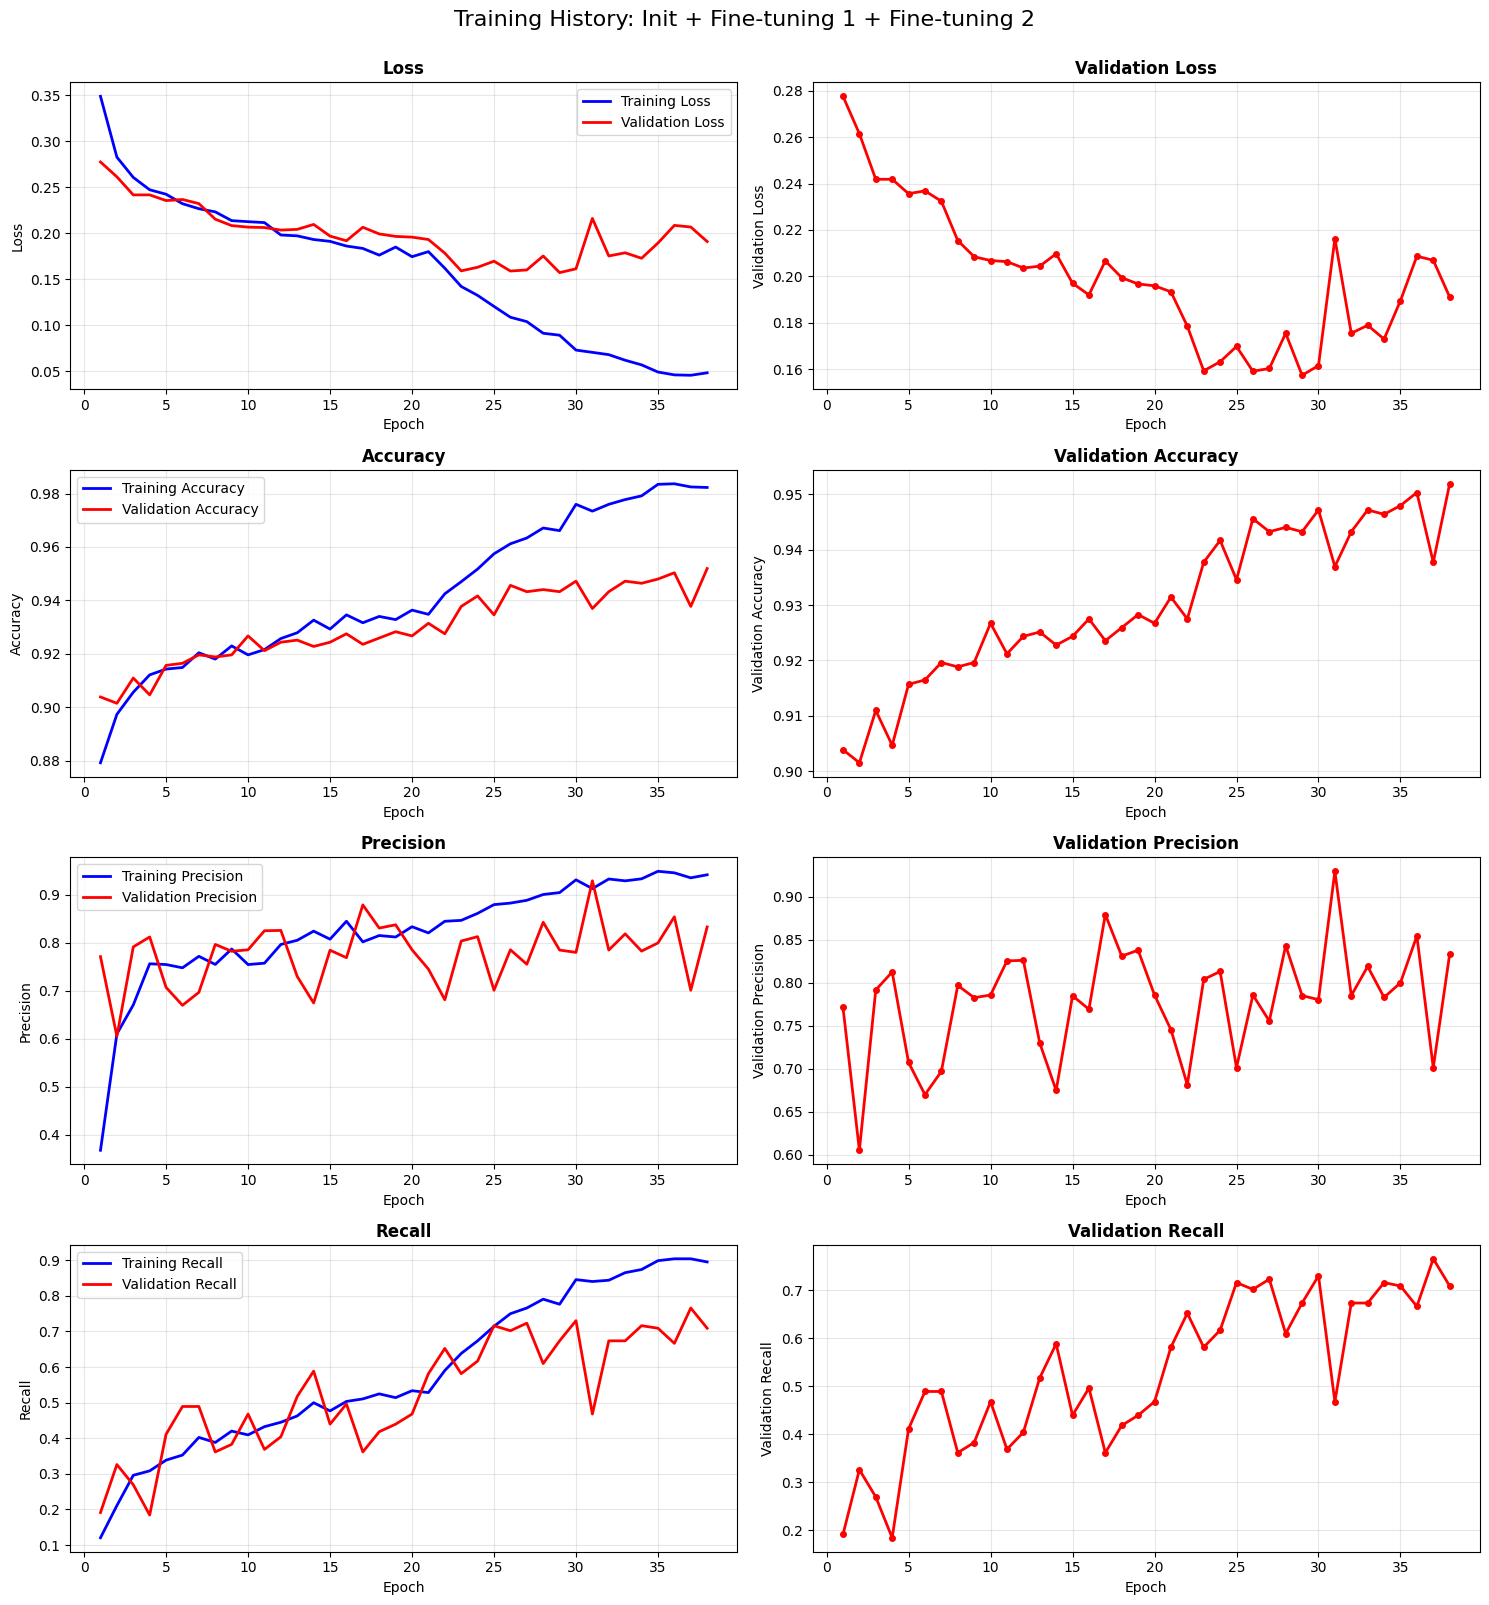


最佳指標:
最低 Validation Loss:      0.1573 (Epoch 29)
最高 Validation Accuracy:  0.9519 (Epoch 38)
最高 Validation Precision: 0.9296 (Epoch 31)
最高 Validation Recall:    0.7660 (Epoch 37)


In [10]:
# 合併三階段訓練歷史
val_loss = history.history['val_loss'] + history2.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history2.history['val_accuracy']
val_recall = history.history['val_recall'] + history2.history['val_recall']
val_precision = history.history['val_precision'] + history2.history['val_precision']

train_loss = history.history['loss'] + history2.history['loss']
train_accuracy = history.history['accuracy'] + history2.history['accuracy']
train_recall = history.history['recall'] + history2.history['recall']
train_precision = history.history['precision'] + history2.history['precision']

epochs_range = range(1, len(val_loss) + 1)

# 建立 4x2 子圖（新增 Precision）
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
fig.suptitle('Training History: Init + Fine-tuning 1 + Fine-tuning 2', fontsize=16, y=1.00)

# Loss
axes[0, 0].plot(epochs_range, train_loss, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss only
axes[0, 1].plot(epochs_range, val_loss, 'r-', linewidth=2, marker='o', markersize=4)
axes[0, 1].set_title('Validation Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].grid(True, alpha=0.3)

# Accuracy
axes[1, 0].plot(epochs_range, train_accuracy, 'b-', label='Training Accuracy', linewidth=2)
axes[1, 0].plot(epochs_range, val_accuracy, 'r-', label='Validation Accuracy', linewidth=2)
axes[1, 0].set_title('Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy only
axes[1, 1].plot(epochs_range, val_accuracy, 'r-', linewidth=2, marker='o', markersize=4)
axes[1, 1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].grid(True, alpha=0.3)

# Precision
axes[2, 0].plot(epochs_range, train_precision, 'b-', label='Training Precision', linewidth=2)
axes[2, 0].plot(epochs_range, val_precision, 'r-', label='Validation Precision', linewidth=2)
axes[2, 0].set_title('Precision', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Validation Precision only
axes[2, 1].plot(epochs_range, val_precision, 'r-', linewidth=2, marker='o', markersize=4)
axes[2, 1].set_title('Validation Precision', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Validation Precision')
axes[2, 1].grid(True, alpha=0.3)

# Recall
axes[3, 0].plot(epochs_range, train_recall, 'b-', label='Training Recall', linewidth=2)
axes[3, 0].plot(epochs_range, val_recall, 'r-', label='Validation Recall', linewidth=2)
axes[3, 0].set_title('Recall', fontsize=12, fontweight='bold')
axes[3, 0].set_xlabel('Epoch')
axes[3, 0].set_ylabel('Recall')
axes[3, 0].legend()
axes[3, 0].grid(True, alpha=0.3)

# Validation Recall only
axes[3, 1].plot(epochs_range, val_recall, 'r-', linewidth=2, marker='o', markersize=4)
axes[3, 1].set_title('Validation Recall', fontsize=12, fontweight='bold')
axes[3, 1].set_xlabel('Epoch')
axes[3, 1].set_ylabel('Validation Recall')
axes[3, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 印出最佳指標
best_val_loss_epoch = val_loss.index(min(val_loss)) + 1
best_val_acc_epoch = val_accuracy.index(max(val_accuracy)) + 1
best_val_recall_epoch = val_recall.index(max(val_recall)) + 1
best_val_precision_epoch = val_precision.index(max(val_precision)) + 1

print(f"\n{'='*60}")
print(f"最佳指標:")
print(f"{'='*60}")
print(f"最低 Validation Loss:      {min(val_loss):.4f} (Epoch {best_val_loss_epoch})")
print(f"最高 Validation Accuracy:  {max(val_accuracy):.4f} (Epoch {best_val_acc_epoch})")
print(f"最高 Validation Precision: {max(val_precision):.4f} (Epoch {best_val_precision_epoch})")
print(f"最高 Validation Recall:    {max(val_recall):.4f} (Epoch {best_val_recall_epoch})")
print(f"{'='*60}")